# Covid-19 Analysis (United States of America)

# Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 데이터 로드 및 데이터 준비

#### 사용된 데이터세트 정보

아래에는 4개의 데이터 프레임이 나열되어 있으며 각 데이터 프레임에는 고유한 데이터 세트가 로드되어 있습니다.

Confirmed_cases: 이 데이터 프레임에는 지금까지 미국에서 확인된 총 사례의 데이터 집합이 있습니다. 이 데이터 세트는 JHU CSSE(Johns Hopkins University Center for Systems Science and Engineering) github 리포지토리에서 제공되며 실시간으로 업데이트됩니다.

death_cases: 이 데이터 프레임에는 지금까지 미국에서 발생한 총 사망 사례의 데이터 세트가 있으며 JHU CSSE에서도 검색되어 실시간으로 업데이트됩니다.

demographics_cases: 이 데이터 프레임에는 인구 통계(연령 그룹 및 성별)별 총 사망자 데이터 세트가 있습니다.

백신 접종_df: 이 데이터 프레임에는 미국에서 2020년부터 현재까지 백신 접종 횟수를 포함하는 데이터 세트가 있습니다(즉, 첫 번째 접종을 완료한 사람 또는 완전히 예방 접종을 받은 사람).

In [4]:
# 라이브 업데이트 데이터 다운로드
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
death_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

# 원치 않는 열 제거
confirmed_cases.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS','Country_Region', 'Lat', 'Long_','Combined_Key'], axis = 1, 
                     inplace = True)
death_cases.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS','Country_Region', 'Lat', 'Long_','Combined_Key'], axis = 1, 
                 inplace = True)

# County로 Admin2 열 이름 바꾸기
confirmed_cases.rename(columns = {'Admin2':'County'}, inplace = True)
death_cases.rename(columns = {'Admin2':'County'}, inplace = True)


# CSV 파일에서 인구 통계 및 예방 접종 데이터 로드
demographic_cases = pd.read_csv('Provisional_COVID-19_Deaths_by_Sex_and_Age.csv')
vaccination_df = pd.read_csv('country_vaccinations.csv')

# 예방 접종 및 인구 통계 데이터를 모두 미국 국가로만 필터링하고 기타 원치 않는 열 제거
vaccination_df = vaccination_df[vaccination_df['country']=='United States']
vaccination_df = vaccination_df[['country','date','total_vaccinations','people_vaccinated','people_fully_vaccinated']]
demographic_cases = demographic_cases[(demographic_cases['Group'] == 'By Total') & (demographic_cases['State'] == 'United States')]
demographic_cases = demographic_cases[['State','Sex','Age Group','COVID-19 Deaths']]

# 하나의 데이터 프레임에서 두 데이터 세트 병합
df = pd.concat([vaccination_df, demographic_cases], axis = 0)

# 데이터 분석 및 시각화

**데이터 세트에서 유용한 통찰력을 얻고 다른 플롯을 사용하여 동일한 시각화.**

In [5]:
total_cases = sum(confirmed_cases[confirmed_cases.iloc[:,-1:].columns[0]])
print('Total Confirmed Cases :', total_cases)

print('--------------------')

total_deaths = sum(death_cases[death_cases.iloc[:,-1:].columns[0]])
print('Total Deaths:', total_deaths)

Total Confirmed Cases : 42543510
--------------------
Total Deaths: 681192


### 확인된 사례 및 사망이 있는 상위 10개 주

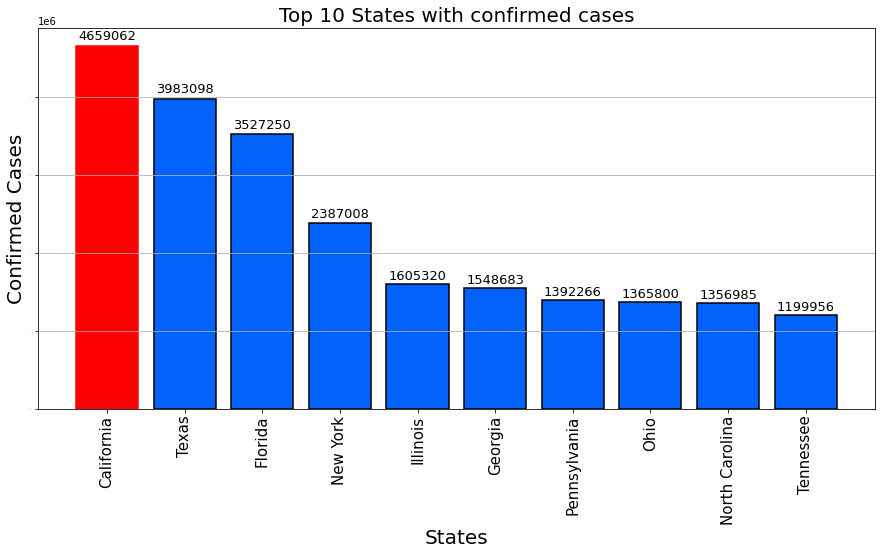

,Province_State,Last Date Cases
5,California,4659062
49,Texas,3983098
11,Florida,3527250
36,New York,2387008
17,Illinois,1605320
12,Georgia,1548683
43,Pennsylvania,1392266
40,Ohio,1365800
37,North Carolina,1356985
48,Tennessee,1199956


In [6]:
cases = confirmed_cases.groupby('Province_State')[[confirmed_cases.iloc[:,-1:].columns[0]]].sum()
cases.reset_index(inplace = True)
cases = cases[['Province_State', cases.iloc[:,-1:].columns[0]]]
top_10 = cases.nlargest(10,cases.iloc[:,-1:].columns[0])
top_10.rename(columns = {top_10.iloc[:,-1:].columns[0]:'Last Date Cases'}, inplace = True)
plt.figure(figsize=(15,7)) # 그림 크기 설정
plt.grid(b=True, which='major', axis='y') # 그리드 설정
plt.rcParams['axes.facecolor'] = '#D2FFF1' # 배경색
barlist = plt.bar(top_10['Province_State'],top_10[top_10.iloc[:,-1:].columns[0]],color = '#0462FC',linewidth=1.5,edgecolor='k') 
plt.title('Top 10 States with confirmed cases',fontsize=20) # 제목 설정

# x 및 y 축에 대한 매개변수 설정
plt.xticks(fontsize=15,rotation = 90) 
plt.yticks(fontsize=0)
plt.xlabel('States',fontsize=20,color='k')
plt.ylabel('Confirmed Cases',fontsize=20,color='k')

# 그래프의 레이블에 대한 함수
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 1.01*(h+5), '%d'%int(h),
                    ha='center', va='bottom',fontsize=13)

autolabel(barlist)
barlist[0].set_color('r') # 상위 카운티 색상 설정
plt.show()

top_10

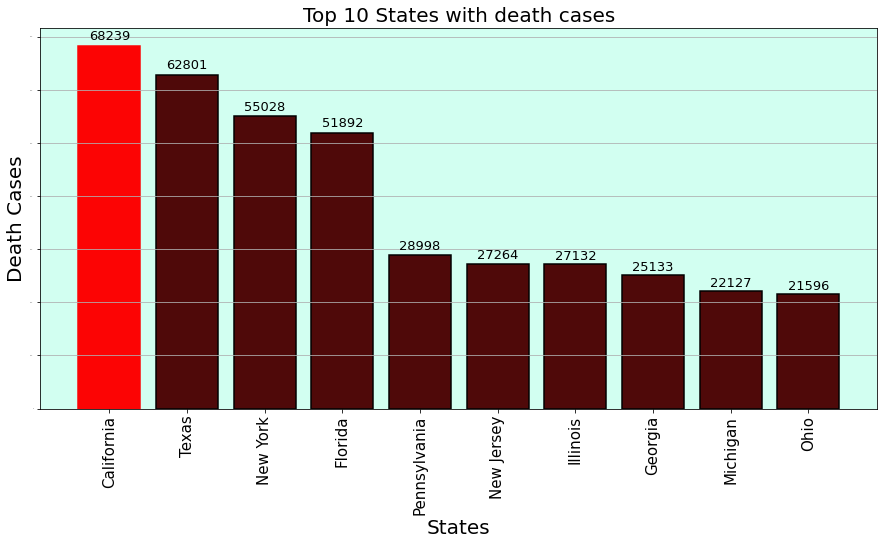

,Province_State,Last Date Cases
5,California,68239
49,Texas,62801
36,New York,55028
11,Florida,51892
43,Pennsylvania,28998
34,New Jersey,27264
17,Illinois,27132
12,Georgia,25133
26,Michigan,22127
40,Ohio,21596


In [7]:
deaths = death_cases.groupby('Province_State')[[confirmed_cases.iloc[:,-1:].columns[0]]].sum()
deaths.reset_index(inplace = True)
deaths = deaths[['Province_State', deaths.iloc[:,-1:].columns[0]]]
top_10 = deaths.nlargest(10,deaths.iloc[:,-1:].columns[0])
top_10.rename(columns = {top_10.iloc[:,-1:].columns[0]:'Last Date Cases'}, inplace = True)
plt.figure(figsize=(15,7)) # setting figure size
plt.grid(b=True, which='major', axis='y') # setting grids
plt.rcParams['axes.facecolor'] = '#D2FFF1' # background color
barlist = plt.bar(top_10['Province_State'],top_10[top_10.iloc[:,-1:].columns[0]],color = '#4F0909',linewidth=1.5,edgecolor='k')
plt.title('Top 10 States with death cases',fontsize=20)
# Setting parameters for x and y axis
plt.xticks(fontsize=15,rotation = 90)
plt.yticks(fontsize=0)
plt.xlabel('States',fontsize=20,color='k')
plt.ylabel('Death Cases',fontsize=20,color='k')
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 1.01*(h+5), '%d'%int(h),
                    ha='center', va='bottom',fontsize=13)

autolabel(barlist)
barlist[0].set_color('#FC0404')
plt.show()
top_10

### 날짜별 총 확인 및 사망 사례

- 2021년 1월 1일부터 현재까지 2건의 사례를 날짜별로 시각화하여 사례가 어떻게 증가했는지 확인합니다.
- 두 경우 모두에 대한 선 플롯을 플로팅합니다
- 3500만 이상의 사례가 있는 임계구간을 포함하고 사망자의 경우 500,000입니다..

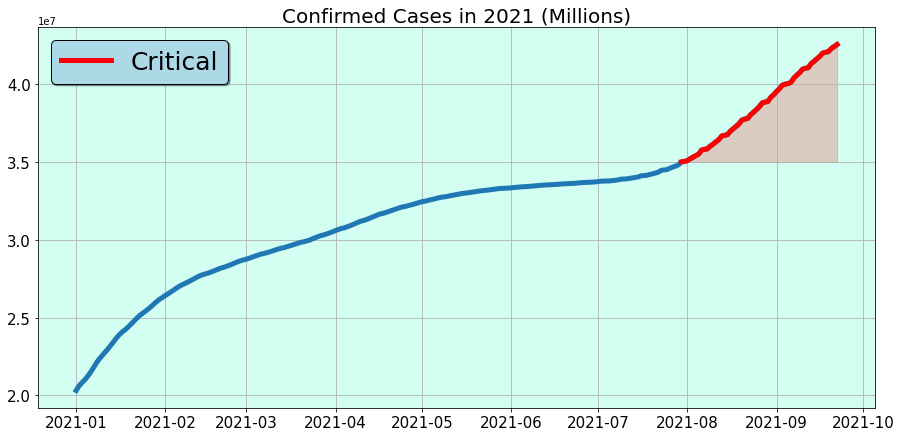

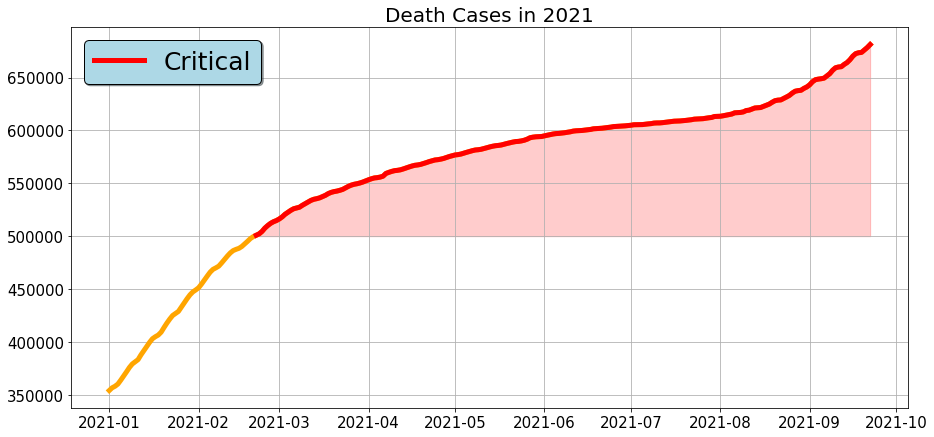

In [8]:
#실제 데이터 프레임에서 지방 상태를 삭제하고 인덱스 1에서 슬라이싱하여 날짜 프레임을 적용합니다. 
confirmed_cases_t = confirmed_cases.drop('Province_State', axis = 1).transpose()[1:]

# 모든 날짜에 카운티별 모든 사례의 합계 계산
confirmed_cases_t["total cases"] = confirmed_cases_t.sum(axis=1)

# 인덱스를 datetime으로 변경
confirmed_cases_t.index = pd.to_datetime(confirmed_cases_t.index)
confirmed_cases_t.reset_index(inplace = True)

# 데이터 프레임을 2021 케이스로만 필터링
confirmed_cases_t = confirmed_cases_t[confirmed_cases_t['index'] > '2020-12-31']

# 360만 건 이상의 경우에 대해 크리티컬 케이스 컬럼 생성
critical = []
for x in confirmed_cases_t['total cases']:
    if x > 35000000:
        critical.append(x)
    else:
        critical.append(None)
confirmed_cases_t['Critical'] = critical

# 결과 시각화

# 도형 크기, 배경색, 격자, 제목 설정
plt.figure(figsize=(15,7))
plt.grid(b=True, which='major', axis='both')
plt.rcParams['axes.facecolor'] = '#FFFFFF'
plt.title('Confirmed Cases in 2021 (Millions)', fontsize = 20)
plt.plot(confirmed_cases_t['index'], confirmed_cases_t['total cases'], linewidth = 5) # plot for total cases
plt.plot(confirmed_cases_t['index'], confirmed_cases_t['Critical'], color = 'r', linewidth = 5, label = 'Critical')
confirmed_cases_t['Critcal Condition'] = 35000000
plt.fill_between(confirmed_cases_t['index'], confirmed_cases_t['Critical'], confirmed_cases_t['Critcal Condition'], color='red',
                 alpha=0.2)
plt.legend(fontsize=25,shadow=True,facecolor='lightblue',edgecolor = 'k')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

death_cases_t = death_cases.drop(['Province_State','Population'], axis = 1).transpose()[1:]
death_cases_t["total cases"] = death_cases_t.sum(axis=1)
death_cases_t.index = pd.to_datetime(death_cases_t.index)
death_cases_t.reset_index(inplace = True)
death_cases_t = death_cases_t[death_cases_t['index'] > '2020-12-31']
critical = []
for x in death_cases_t['total cases']:
    if x > 500000:
        critical.append(x)
    else:
        critical.append(None)
death_cases_t['Critical'] = critical
plt.figure(figsize=(15,7))
plt.grid(b=True, which='major', axis='both')
plt.rcParams['axes.facecolor'] = '#FFFFFF'
plt.title('Death Cases in 2021', fontsize = 20)
plt.plot(death_cases_t['index'], death_cases_t['total cases'], color = 'orange', linewidth = 5)
plt.plot(death_cases_t['index'], death_cases_t['Critical'], color = 'r', linewidth = 5, label = 'Critical')
death_cases_t['Critcal Condition'] = 500000
plt.fill_between(death_cases_t['index'], death_cases_t['Critical'], death_cases_t['Critcal Condition'], color='red',
                 alpha=0.2)
plt.legend(fontsize=25,shadow=True,facecolor='lightblue',edgecolor = 'k')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 미국의 예방 접종 용량

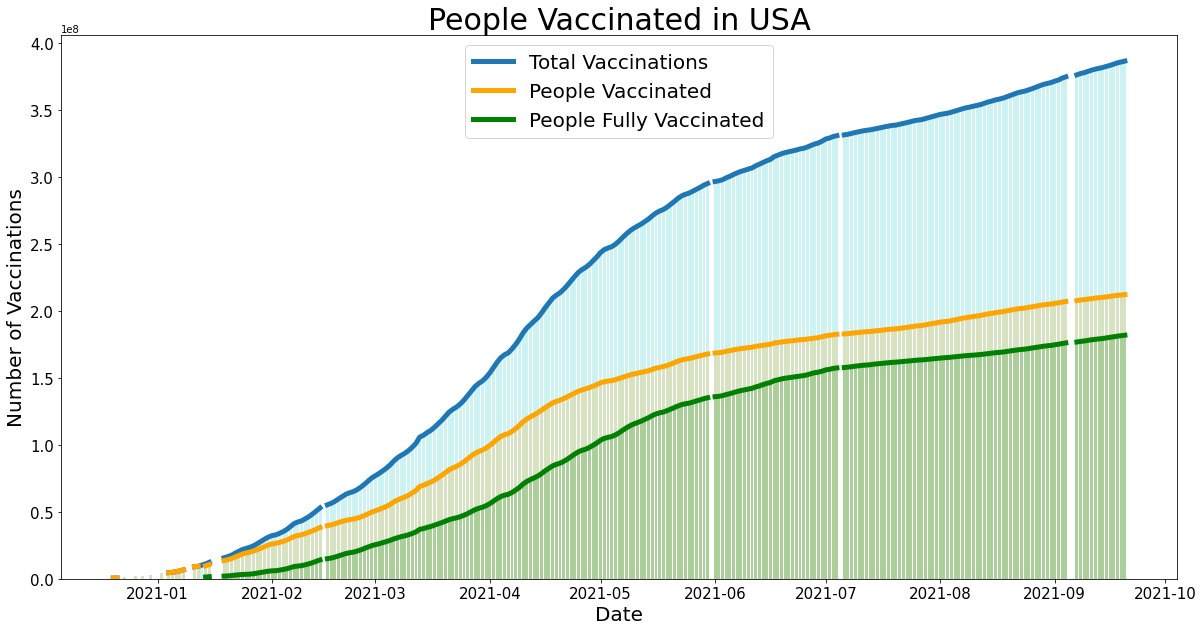

In [9]:
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])
plt.figure(figsize=(20,10))
plt.title('People Vaccinated in USA',fontsize=30)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Number of Vaccinations',fontsize=20)
plt.plot(vaccination_df['date'],vaccination_df['total_vaccinations'],label='Total Vaccinations',linewidth=5)
plt.plot(vaccination_df['date'],vaccination_df['people_vaccinated'],label='People Vaccinated',linewidth=5,color='orange')
plt.plot(vaccination_df['date'],vaccination_df['people_fully_vaccinated'],label='People Fully Vaccinated',linewidth=5,color='green')
plt.bar(vaccination_df['date'],vaccination_df['total_vaccinations'],alpha=0.2,color='c')
plt.bar(vaccination_df['date'],vaccination_df['people_vaccinated'],alpha=0.2,color='orange')
plt.bar(vaccination_df['date'],vaccination_df['people_fully_vaccinated'],alpha=0.2,color='green')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize = 20)
plt.show()

### 연령대 및 성별에 따른 미국 사망 사례 시각화

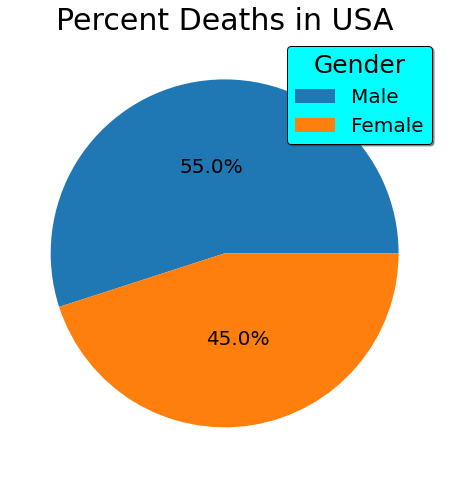

In [10]:
male = demographic_cases[(demographic_cases['Sex'] == 'Male') & (demographic_cases['Age Group'] == 'All Ages')]
total_deaths_male = male['COVID-19 Deaths'].sum()
female = demographic_cases[(demographic_cases['Sex'] == 'Female') & (demographic_cases['Age Group'] == 'All Ages')]
total_deaths_female = female['COVID-19 Deaths'].sum()
percent_list = [(total_deaths_male/(total_deaths_male+total_deaths_female)),(total_deaths_female/(total_deaths_male+total_deaths_female))]
label = ['Male','Female']

plt.figure(figsize=(10,8))
plt.title('Percent Deaths in USA', fontsize = 30)
plt.pie(percent_list,autopct='%1.1f%%', pctdistance= 0.5,textprops={'fontsize': 20})
plt.legend(label,loc='best',shadow=True,facecolor='cyan',edgecolor = 'k',title='Gender',fontsize = 20, title_fontsize=25)
plt.show()

<BarContainer object of 16 artists>

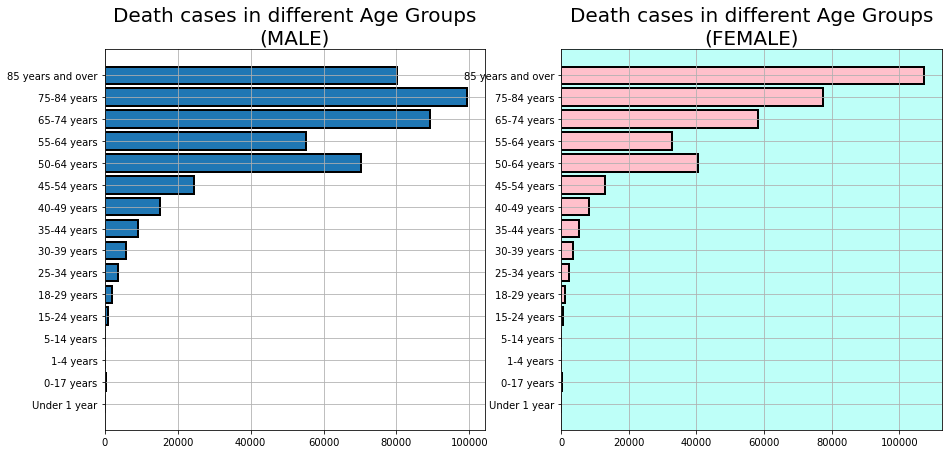

In [11]:
male = demographic_cases[demographic_cases['Sex'] == 'Male']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.grid(b=True, which='major', axis='both')
plt.title('Death cases in different Age Groups\n(MALE)', fontsize = 20)
plt.rcParams['axes.facecolor'] = '#BEFFF8'
plt.barh(male[1:]['Age Group'], male[1:]['COVID-19 Deaths'], edgecolor = 'k', linewidth = 2 )

female = demographic_cases[demographic_cases['Sex'] == 'Female']
plt.subplot(1,2,2)
plt.grid(b=True, which='major', axis='both')
plt.title('Death cases in different Age Groups\n(FEMALE)', fontsize = 20)
plt.rcParams['axes.facecolor'] = '#BEFFF8'
plt.barh(female[1:]['Age Group'], female[1:]['COVID-19 Deaths'], color = 'pink', edgecolor = 'k', linewidth =2)

# 선형 회귀 및 의사 결정 트리 회귀 피팅 (기계 학습)

In [12]:
# 데이터 세트의 학습 및 테스트 데이터로 분할
vaccination_df.dropna(inplace = True)
X = vaccination_df[['total_vaccinations','people_vaccinated']]
y = vaccination_df['people_fully_vaccinated']

X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

In [13]:
# 베이스라인 설정
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Mean y_train: ', y_train.mean())
print('Baseline MAE:', baseline_mae)

Mean y_train:  82644621.0054945
Baseline MAE: 50732501.972467095


In [14]:
# 예측자 클래스 가져오기
from sklearn.linear_model import LinearRegression

# 예측자 인스턴스화
model = LinearRegression()

# 데이터에 대한 예측 변수 맞추기
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# 측정항목 확인

# 데이터에 대한 MAE 계산 -> 평균제곱오차
training_mae = mean_absolute_error(y_train,model.predict(X_train))

print('Training MAE of Linear Regressor:', training_mae)
testing_mae = mean_absolute_error(y_test,model.predict(X_test))

print('Testing MAE of Linear Regressor:', testing_mae)

# 데이터에 대한 RMSE 계산 제곱 표준 편차
print('Training RMSE:', mean_squared_error(y_train,model.predict(X_train), squared = False))
print('Test RMSE:', mean_squared_error(y_test,model.predict(X_test), squared = False))

# 데이터에 대한 r2 계산
print('Training R^2 Score:', model.score(X_train, y_train))
print('Test R^2 Score:', model.score(X_test, y_test))

Training MAE of Linear Regressor: 523017.3501186502
Testing MAE of Linear Regressor: 1111012.585141324
Training RMSE: 739580.6293905347
Test RMSE: 1695971.5573362096
Training R^2 Score: 0.9998242112741175
Test R^2 Score: 0.9181827172824814


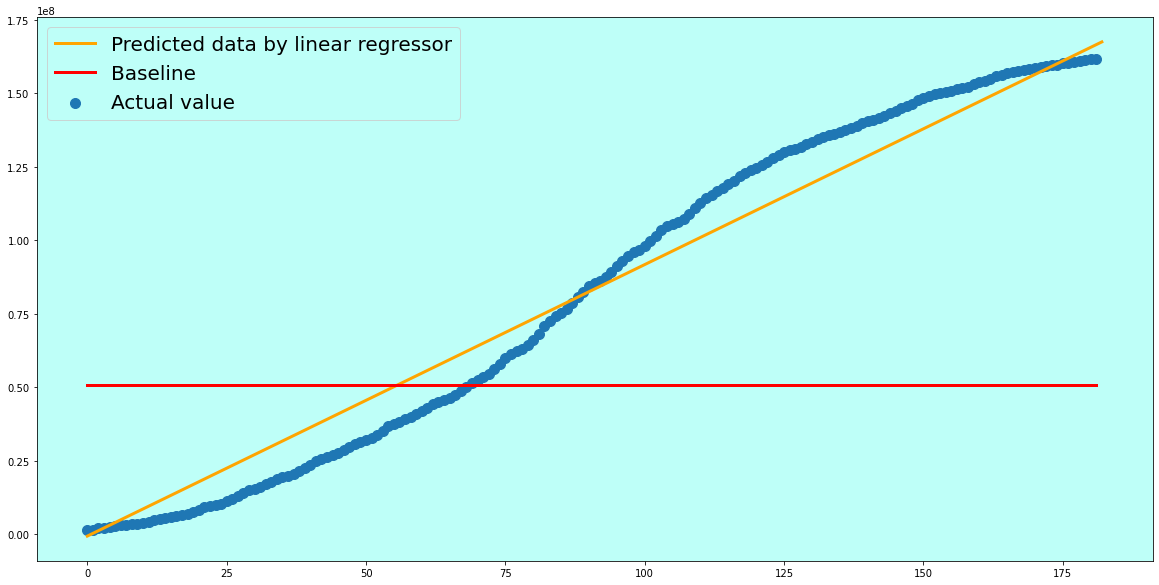

In [16]:
plt.figure(figsize = (20,10))
y1 = model.coef_[0]*y_train[0:1]+model.intercept_
y2 = model.coef_[0]*y_train[-1:]+model.intercept_
plt.plot([0,len(y_train)], [y1,y2], '-r', color='orange', label='Predicted data by linear regressor',linewidth = 3)
plt.scatter(range(0,len(y_train)), y_train, label='Actual value',s = 100)
plt.plot(range(0,len(y_train)), [baseline_mae]*len(y_train), label = 'Baseline', color = 'red',linewidth = 3)
plt.legend(fontsize = 20)
plt.show()

In [17]:
# 예측자 클래스 가져오기
from sklearn.tree import DecisionTreeRegressor

# 예측자 인스턴스화

model1 = DecisionTreeRegressor(criterion='mae')

# 데이터에 대한 예측 변수 맞추기
model1.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [18]:
# 측정항목 확인

# 데이터에 대한 MAE 계산
training_mae = mean_absolute_error(y_train,model1.predict(X_train))

print('Training MAE of Linear Regressor:', training_mae)
# 테스트 데이터에 대한 RMSE 계산
print('Training RMSE:', mean_squared_error(y_train,model1.predict(X_train), squared = False))

# 대한 r2 계산
print('Training R^2 Score:', model1.score(X_train, y_train))

Training MAE of Linear Regressor: 0.0
Training RMSE: 0.0
Training R^2 Score: 1.0


Stretch Goal:
The goal of this task is to build a model that predicts the future cases. Building a machine learning model includes following steps:

- Data Windowing with 12 time steps 
- Fitting LSTM deep learning models on the dataset
- Predictions on the dataset
- Calculating future cases for 3 months

In [19]:
#@title
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM

In [20]:
#@title
# confirmed_cases_t = confirmed_cases_t[['index','total cases']]
# confirmed_cases_t.set_index('index',inplace = True)
# scaler=StandardScaler()
# df1=scaler.fit_transform(np.array(confirmed_cases_t).reshape(-1,1))
# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]   
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])
#     return np.array(dataX), np.array(dataY)
# time_step = 12
# X_train, y_train = create_dataset(df1, time_step)
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [21]:
#@title
# # Creating a model

# model = Sequential()
# # Input layer 
# model.add(LSTM (64, return_sequences = True, 
#              input_shape = [X_train.shape[1], X_train.shape[2]]))
# # Hidden layer
# model.add(LSTM(64))    
# model.add(Dense(units = 1)) 
# #Compile model
# model.compile(optimizer='adam',loss='mse')

# # Fitting a model

# model.fit(X_train,y_train,epochs=50,batch_size=64)

In [22]:
#@title
# train_predict=model.predict(X_train)
# y_train=scaler.inverse_transform(y_train.reshape(-1,1))
# train_predict=scaler.inverse_transform(train_predict)
# r2_score(y_train,train_predict)
# print('Accuracy : ', r2_score(y_train,train_predict)*100)

In [23]:
#@title
# # Predicting future cases for 2 months
# x_input=df1[-12:].reshape(1,-1)
# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()
# lst_output=[]
# n_steps=12
# i=0
# while(i<90):
    
#     if(len(temp_input)>12):
#         x_input=np.array(temp_input[1:])
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         yhat = model.predict(x_input, verbose=0)
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         temp_input.extend(yhat[0].tolist())
#         lst_output.extend(yhat.tolist())
#         i=i+1


In [24]:
#@title
# forecast_dates = pd.date_range(start='9/21/2021', periods=90)
# forecast = pd.DataFrame(forecast_dates,columns=['Dates'])
# df3=scaler.inverse_transform(lst_output)
# forecast['Forecast'] = df3
# plt.figure(figsize = (20,10))
# plt.title('Future Cases for 3 months', fontsize = 30)
# plt.plot(confirmed_cases_t.index, confirmed_cases_t['total cases'], linewidth = 5)
# plt.plot(forecast['Dates'],forecast['Forecast'],label = 'Future Cases', linewidth = 5)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.xlabel('Date', fontsize = 20)
# plt.ylabel('Confirmed Cases', fontsize = 20)
# plt.legend(fontsize = 40)
# plt.show()